# A/B Test significance in Python

Reference:
- https://cosmiccoding.com.au/tutorials/abtests/

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.stats.api as sm
from scipy.stats import binom, mannwhitneyu, norm, ttest_ind

In [2]:
num_a, num_b = 550, 450
click_a, click_b = 48, 56
rate_a, rate_b = click_a / num_a, click_b / num_b
rate_a, rate_b

(0.08727272727272728, 0.12444444444444444)

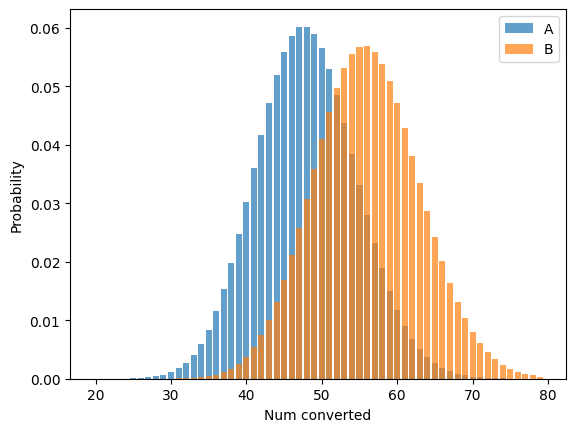

In [3]:
# Determine the probability of having x click through
clicks = np.arange(20, 80)
prob_a = binom(num_a, rate_a).pmf(clicks)
prob_b = binom(num_b, rate_b).pmf(clicks)

# Make the bar plots.
plt.bar(clicks, prob_a, label="A", alpha=0.7)
plt.bar(clicks, prob_b, label="B", alpha=0.7)
plt.xlabel("Num converted")
plt.ylabel("Probability")
plt.legend();

Normal approximation:
- https://en.wikipedia.org/wiki/Binomial_distribution#Normal_approximation

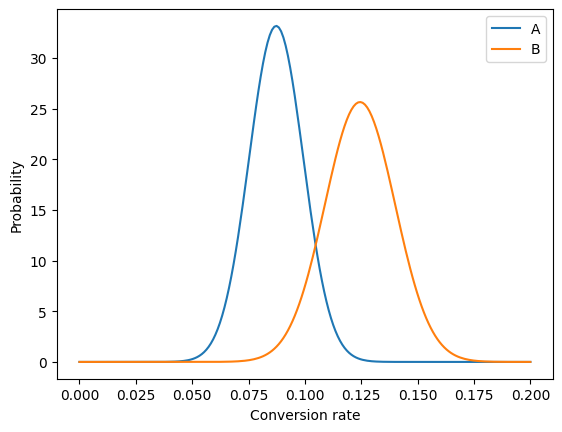

In [4]:
std_a = np.sqrt(rate_a * (1 - rate_a) / num_a)
std_b = np.sqrt(rate_b * (1 - rate_b) / num_b)

click_rate = np.linspace(0, 0.2, 200)
prob_a = norm(rate_a, std_a).pdf(click_rate)
prob_b = norm(rate_b, std_b).pdf(click_rate)

# Make the bar plots.
plt.plot(click_rate, prob_a, label="A")
plt.plot(click_rate, prob_b, label="B")
plt.xlabel("Conversion rate")
plt.ylabel("Probability")
plt.legend();

In [5]:
z_score = (rate_b - rate_a) / np.sqrt(std_a**2 + std_b**2)

print(f"z-score is {z_score:0.3f}, with p-value {norm().sf(z_score):0.3f}")

z-score is 1.890, with p-value 0.029


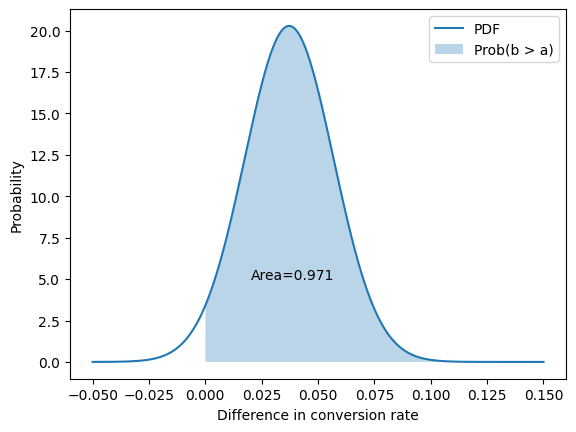

In [6]:
p = norm(rate_b - rate_a, np.sqrt(std_a**2 + std_b**2))
x = np.linspace(-0.05, 0.15, 1000)
y = p.pdf(x)

area_under_curve = p.sf(0)
plt.plot(x, y, label="PDF")
plt.fill_between(x, 0, y, where=x > 0, label="Prob(b > a)", alpha=0.3)
plt.annotate(f"Area={area_under_curve:0.3f}", (0.02, 5))
plt.xlabel("Difference in conversion rate")
plt.ylabel("Probability")
plt.legend();

In [7]:
def get_confidence_ab_test(click_a, num_a, click_b, num_b):
    rate_a = click_a / num_a
    rate_b = click_b / num_b
    std_a = np.sqrt(rate_a * (1 - rate_a) / num_a)
    std_b = np.sqrt(rate_b * (1 - rate_b) / num_b)
    z_score = (rate_b - rate_a) / np.sqrt(std_a**2 + std_b**2)
    return norm.cdf(z_score)

In [8]:
get_confidence_ab_test(click_a, num_a, click_b, num_b)

0.9705973498275782

In [9]:
# Draw 10000 samples of possible rates for a and b
n = 10000
rates_a = norm(rate_a, std_a).rvs(n)
rates_b = norm(rate_b, std_b).rvs(n)
b_better = (rates_b > rates_a).mean()
print(f"B is better than A {b_better:0.1%} of the time")

B is better than A 97.2% of the time


In [10]:
a_dist = np.zeros(num_a)
a_dist[:click_a] = 1
b_dist = np.zeros(num_b)
b_dist[:click_b] = 1
zscore, prob = ttest_ind(a_dist, b_dist, equal_var=False)
print(
    f"z-score is {zscore:0.2f}, p-value is {prob:0.3f} (two tailed), {prob/2:0.3f} (one tailed)"
)

z-score is -1.89, p-value is 0.059 (two tailed), 0.030 (one tailed)


In [11]:
stat, p_value = mannwhitneyu(a_dist, b_dist, alternative="less")
print(f"Mann-Whitney U test for null hypothesis B <= A is {p_value:0.3f}")

Mann-Whitney U test for null hypothesis B <= A is 0.028


In [12]:
tstat, pvalue = sm.test_proportions_2indep(
    click_b, num_b, click_a, num_a, alternative="larger", return_results=False
)
tstat, pvalue

(1.889839963839522, 0.029389683451596548)

In [13]:
tstat, pvalue = sm.proportions_ztest(
    count=[click_b, click_a], nobs=[num_b, num_a], alternative="larger", prop_var=False
)
tstat, pvalue

(1.9157090514848982, 0.02770106983215799)